In [1]:
# Initial Imports
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
from dotenv import load_dotenv
import numpy as np
import alpaca_trade_api as tradeapi
import seaborn as sns

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

In [3]:
# import the top transfers csv which will give us the money that each teams spends on buying players (Team_to column and Transfer_fee column)

top_transfers_file_path = Path("Resources/top250-00-19.csv")
all_transfers = pd.read_csv(top_transfers_file_path)
all_transfers

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Market_value,Transfer_fee
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000
...,...,...,...,...,...,...,...,...,...,...
4695,Jasmin Kurtic,Attacking Midfield,29,Atalanta,Serie A,SPAL,Serie A,2018-2019,5000000.0,4800000
4696,Tchê Tchê,Central Midfield,25,Palmeiras,Série A,Dynamo Kyiv,Premier Liga,2018-2019,3000000.0,4800000
4697,Silvan Widmer,Right-Back,25,Udinese Calcio,Serie A,FC Basel,Super League,2018-2019,8500000.0,4500000
4698,Yuya Osako,Second Striker,28,1. FC Köln,2.Bundesliga,Werder Bremen,1.Bundesliga,2018-2019,4500000.0,4500000


In [4]:
# see the data types in order to help make decisions on how to clean, slice and dice the data

print(all_transfers.dtypes)

Name             object
Position         object
Age               int64
Team_from        object
League_from      object
Team_to          object
League_to        object
Season           object
Market_value    float64
Transfer_fee      int64
dtype: object


In [5]:
# convert name, position, teams, leagues season to strings to in order to search for the teams we want to select 
# convert the numbers in the transfer fee columns to float to match the numbers in other dataframes which will be read in later
all_transfers[["Name", "Position", "Team_from", "Team_to", "League_to","Season"]] = all_transfers[["Name", "Position", "Team_from", "Team_to", "League_to","Season"]].astype(str)
all_transfers[["Transfer_fee"]] = all_transfers[["Transfer_fee"]].astype(float)

In [6]:
print(all_transfers.dtypes)

Name             object
Position         object
Age               int64
Team_from        object
League_from      object
Team_to          object
League_to        object
Season           object
Market_value    float64
Transfer_fee    float64
dtype: object


In [7]:
# in order to have a consistent datetime index across all the data frames, the name of the season must be condensed into a single year. 
# In order to do this we must split the string into two columns.

seasons = all_transfers["Season"].str.split("-", expand=True)
all_transfers["Season 1"] = seasons[0]
all_transfers["Season 2"] = seasons[1]    
all_transfers

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Market_value,Transfer_fee,Season 1,Season 2
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000.0,2000,2001
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000.0,2000,2001
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000.0,2000,2001
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000.0,2000,2001
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000.0,2000,2001
...,...,...,...,...,...,...,...,...,...,...,...,...
4695,Jasmin Kurtic,Attacking Midfield,29,Atalanta,Serie A,SPAL,Serie A,2018-2019,5000000.0,4800000.0,2018,2019
4696,Tchê Tchê,Central Midfield,25,Palmeiras,Série A,Dynamo Kyiv,Premier Liga,2018-2019,3000000.0,4800000.0,2018,2019
4697,Silvan Widmer,Right-Back,25,Udinese Calcio,Serie A,FC Basel,Super League,2018-2019,8500000.0,4500000.0,2018,2019
4698,Yuya Osako,Second Striker,28,1. FC Köln,2.Bundesliga,Werder Bremen,1.Bundesliga,2018-2019,4500000.0,4500000.0,2018,2019


In [8]:
# drop the extra season columns so that we only have one column with one year representing the season
all_transfers.drop(columns=["Season", "Season 2"], inplace = True)
all_transfers

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Market_value,Transfer_fee,Season 1
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,NaN,60000000.0,2000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,NaN,56810000.0,2000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,NaN,40000000.0,2000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,NaN,36150000.0,2000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,NaN,34500000.0,2000
...,...,...,...,...,...,...,...,...,...,...
4695,Jasmin Kurtic,Attacking Midfield,29,Atalanta,Serie A,SPAL,Serie A,5000000.0,4800000.0,2018
4696,Tchê Tchê,Central Midfield,25,Palmeiras,Série A,Dynamo Kyiv,Premier Liga,3000000.0,4800000.0,2018
4697,Silvan Widmer,Right-Back,25,Udinese Calcio,Serie A,FC Basel,Super League,8500000.0,4500000.0,2018
4698,Yuya Osako,Second Striker,28,1. FC Köln,2.Bundesliga,Werder Bremen,1.Bundesliga,4500000.0,4500000.0,2018


In [9]:
#change the column name from season to year so that it matches with dataframes that will be read in later
all_transfers = all_transfers.rename(columns={"Season 1" : "Year"})
all_transfers

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Market_value,Transfer_fee,Year
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,NaN,60000000.0,2000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,NaN,56810000.0,2000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,NaN,40000000.0,2000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,NaN,36150000.0,2000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,NaN,34500000.0,2000
...,...,...,...,...,...,...,...,...,...,...
4695,Jasmin Kurtic,Attacking Midfield,29,Atalanta,Serie A,SPAL,Serie A,5000000.0,4800000.0,2018
4696,Tchê Tchê,Central Midfield,25,Palmeiras,Série A,Dynamo Kyiv,Premier Liga,3000000.0,4800000.0,2018
4697,Silvan Widmer,Right-Back,25,Udinese Calcio,Serie A,FC Basel,Super League,8500000.0,4500000.0,2018
4698,Yuya Osako,Second Striker,28,1. FC Köln,2.Bundesliga,Werder Bremen,1.Bundesliga,4500000.0,4500000.0,2018


In [10]:
# set index to the Year in a datetime format
all_transfers.set_index(pd.to_datetime(all_transfers["Year"], infer_datetime_format=True), inplace=True)
all_transfers= all_transfers.drop(columns=["Year"])
all_transfers

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Market_value,Transfer_fee
Year,,,,,,,,,
2000-01-01,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,NaN,60000000.0
2000-01-01,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,NaN,56810000.0
2000-01-01,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,NaN,40000000.0
2000-01-01,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,NaN,36150000.0
2000-01-01,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,NaN,34500000.0
...,...,...,...,...,...,...,...,...,...
2018-01-01,Jasmin Kurtic,Attacking Midfield,29,Atalanta,Serie A,SPAL,Serie A,5000000.0,4800000.0
2018-01-01,Tchê Tchê,Central Midfield,25,Palmeiras,Série A,Dynamo Kyiv,Premier Liga,3000000.0,4800000.0
2018-01-01,Silvan Widmer,Right-Back,25,Udinese Calcio,Serie A,FC Basel,Super League,8500000.0,4500000.0


In [11]:
#drop date component to make the datetime index consistent across all dataframes
all_transfers.index = all_transfers.index.year
all_transfers

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Market_value,Transfer_fee
Year,,,,,,,,,
2000,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,NaN,60000000.0
2000,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,NaN,56810000.0
2000,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,NaN,40000000.0
2000,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,NaN,36150000.0
2000,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,NaN,34500000.0
...,...,...,...,...,...,...,...,...,...
2018,Jasmin Kurtic,Attacking Midfield,29,Atalanta,Serie A,SPAL,Serie A,5000000.0,4800000.0
2018,Tchê Tchê,Central Midfield,25,Palmeiras,Série A,Dynamo Kyiv,Premier Liga,3000000.0,4800000.0
2018,Silvan Widmer,Right-Back,25,Udinese Calcio,Serie A,FC Basel,Super League,8500000.0,4500000.0


In [12]:
# slice date for our overall timeframe for the years from 2010 to 2019
all_transfers = all_transfers.loc["2010":"2019"]
all_transfers.head()

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Market_value,Transfer_fee
Year,,,,,,,,,
2010,Fernando Torres,Centre-Forward,26,Liverpool,Premier League,Chelsea,Premier League,50000000.0,58500000.0
2010,Andy Carroll,Centre-Forward,22,Newcastle,Premier League,Liverpool,Premier League,2500000.0,41000000.0
2010,David Villa,Centre-Forward,28,Valencia CF,LaLiga,FC Barcelona,LaLiga,45000000.0,40000000.0
2010,Edin Dzeko,Centre-Forward,24,VfL Wolfsburg,1.Bundesliga,Man City,Premier League,30000000.0,37000000.0
2010,Ángel Di María,Right Winger,22,Benfica,Liga NOS,Real Madrid,LaLiga,9500000.0,33000000.0


In [13]:
all_transfers.to_csv(r"Resources/all_transfer.csv")

In [14]:
# filter for Paris Saint_Germain, our focus team. Grab just the transfer fees paid by Paris Saint Germainm, which corresponds to the Team_to column with Paris SG in the cell
all_psg_buys = all_transfers[all_transfers["Team_to"].str.contains("Paris SG")]
all_psg_buys

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Market_value,Transfer_fee
Year,,,,,,,,,
2010,Nenê,Attacking Midfield,29,Monaco,Ligue 1,Paris SG,Ligue 1,10000000.0,5000000.0
2011,Javier Pastore,Attacking Midfield,22,US Palermo,Serie A,Paris SG,Ligue 1,21000000.0,42000000.0
2011,Thiago Motta,Defensive Midfield,29,Inter,Serie A,Paris SG,Ligue 1,15000000.0,11500000.0
2011,Kévin Gameiro,Centre-Forward,24,FC Lorient,Ligue 1,Paris SG,Ligue 1,13500000.0,11000000.0
2011,Jérémy Ménez,Second Striker,24,AS Roma,Serie A,Paris SG,Ligue 1,15000000.0,8000000.0
2011,Blaise Matuidi,Central Midfield,24,Saint-Étienne,Ligue 1,Paris SG,Ligue 1,8000000.0,8000000.0
2011,Mohamed Sissoko,Defensive Midfield,26,Juventus,Serie A,Paris SG,Ligue 1,7500000.0,8000000.0
2011,Alex,Centre-Back,29,Chelsea,Premier League,Paris SG,Ligue 1,13000000.0,5000000.0
2011,Salvatore Sirigu,Goalkeeper,24,US Palermo,Serie A,Paris SG,Ligue 1,10000000.0,3900000.0


In [15]:
# get the sum of the transfer fees paid by psg each year, which will be compared against what an investment in FAANG would have done
# group the transfer fees by year and divide by 1,000,000 to match the valuation numbers which are in $100 million
psg_comparison_buys = (all_psg_buys[["Transfer_fee"]].groupby([all_psg_buys.index]).sum())
psg_comparison_buys = psg_comparison_buys/1000000
psg_comparison_buys

,Transfer_fee
Year,
2010,5.00
2011,100.90
2012,149.95
2013,135.90
2014,49.50
2015,116.10
2016,132.50
2017,238.00
2018,135.00


In [18]:
# read in psg valuation csv, which is in $100 millions
# the valuation data comes from a Forbes list of the top 20 most valuable soccer clubs, Paris Saint-Germain did not earn enough to be included on the list until 2013
# set datetime index
psg_valuation_file_path = Path("Resources/psg_valuation.csv")
psg_valuation = pd.read_csv(psg_valuation_file_path, parse_dates=True, index_col='Year', infer_datetime_format=True)
psg_valuation

,Paris Saint-Germain
Year,
2013-12-31,131
2014-12-31,415
2015-12-31,634
2016-12-31,814
2017-12-31,841
2018-12-31,971
2019-12-31,1090


In [19]:
# see the data types in order to help make decisions on how to clean, slice and dice the data

print(psg_valuation.dtypes)

Paris Saint-Germain    int64
dtype: object


In [20]:
# drop date component and just leave year to conform to all our dataframes
psg_valuation.index = psg_valuation.index.year
psg_valuation

,Paris Saint-Germain
Year,
2013,131
2014,415
2015,634
2016,814
2017,841
2018,971
2019,1090


In [21]:
# because psg_valuation already takes into account the subsequent investments (i.e. the Player_in transfer fees), the transfer fees paid will not be added to the psg_valuation dataframe

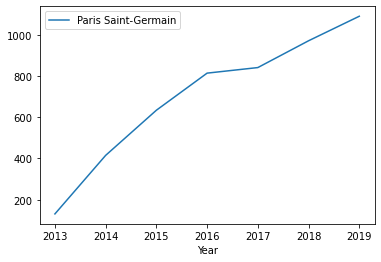

In [22]:
# plot simple line graph showing Paris Saint-Germain valuation
psg_valuation.plot()

In [23]:
# Add alpaca api to get apple, amazon, netflxi and google stock data
# Set Alpaca API key and secret

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object

alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")

In [24]:
# Format current date as ISO format

today = pd.Timestamp("2020-11-18", tz="America/New_York").isoformat()

# Set the tickers to (F)AANG stocks (Facebook's IPO was in 2012 therefore, it is not included in this analysis) 
tickers = ["AAPL", "AMZN", "NFLX", "GOOG"]

# Set timeframe
timeframe = "1D"
start = pd.Timestamp("2010-01-01", tz="America/New_York").isoformat()
end = pd.Timestamp("2018-12-31", tz="America/New_York").isoformat()

In [25]:
# Get aapl stock from 2013 to 2018

closing_prices_df = alpaca.get_barset(tickers, timeframe, start = start, end = end).df

In [26]:
#create an empty dataframe and put the closing prices for the stocks in it
aang_closing_prices = pd.DataFrame()
aang_closing_prices["AAPL"] = closing_prices_df["AAPL"]["close"]
aang_closing_prices["AMZN"] = closing_prices_df["AMZN"]["close"]
aang_closing_prices["NFLX"] = closing_prices_df["NFLX"]["close"]
aang_closing_prices["GOOG"] = closing_prices_df["GOOG"]["close"]

In [27]:
# compute AANG daily returns and cumulative returns
aang_daily_returns = aang_closing_prices.pct_change()
aang_daily_cumulative_returns = (1 + aang_daily_returns).cumprod()
aang_daily_cumulative_returns

,AAPL,AMZN,NFLX,GOOG
2010-01-04 00:00:00-05:00,NaN,NaN,NaN,NaN
2010-01-05 00:00:00-05:00,1.000948,1.005751,0.963463,0.995565
2010-01-06 00:00:00-05:00,0.984868,0.988198,0.997512,0.970421
2010-01-07 00:00:00-05:00,0.983201,0.971019,0.980356,0.947671
2010-01-08 00:00:00-05:00,0.989313,0.997460,0.997512,0.959030
...,...,...,...,...
2018-12-24 00:00:00-05:00,4.791973,10.030699,30.663960,3.111040
2018-12-26 00:00:00-05:00,5.137105,10.986032,33.203248,3.315858
2018-12-27 00:00:00-05:00,5.102461,10.920227,33.459927,3.330855
2018-12-28 00:00:00-05:00,5.100827,11.018673,33.521477,3.306318


In [28]:
# compute AANG yearly returns and cumulative returns
aang_yearly_returns = aang_closing_prices.resample('Y').mean()
aang_yearly_returns = aang_yearly_returns.pct_change()
aang_yearly_cumulative = (1 + aang_yearly_returns).cumprod()
aang_yearly_cumulative.index.names =["Year"]
aang_yearly_cumulative.index = aang_yearly_cumulative.index.year
aang_yearly_cumulative = aang_yearly_cumulative.fillna(0)
aang_yearly_cumulative

,AAPL,AMZN,NFLX,GOOG
Year,,,,
2010,0.000000,0.000000,0.000000,0.000000
2011,1.242248,1.413514,1.634169,1.062181
2012,0.900637,1.583330,0.704674,1.200569
2013,0.783377,2.142000,2.096621,1.651625
2014,1.979426,2.390081,3.417501,2.096557
2015,3.233561,3.436471,5.604316,2.249659
2016,2.817694,5.027561,6.064631,2.776215
2017,4.055334,6.958161,9.829320,3.442022
2018,5.092158,11.798935,18.978116,4.156860


In [29]:
aang_yearly_returns

,AAPL,AMZN,NFLX,GOOG
Year,,,,
2010-12-31 00:00:00-05:00,NaN,NaN,NaN,NaN
2011-12-31 00:00:00-05:00,0.242248,0.413514,0.634169,0.062181
2012-12-31 00:00:00-05:00,-0.274994,0.120137,-0.568787,0.130287
2013-12-31 00:00:00-05:00,-0.130197,0.352845,1.975305,0.375701
2014-12-31 00:00:00-05:00,1.526786,0.115818,0.630004,0.269391
2015-12-31 00:00:00-05:00,0.633585,0.437805,0.639887,0.073025
2016-12-31 00:00:00-05:00,-0.128610,0.463001,0.082136,0.234060
2017-12-31 00:00:00-05:00,0.439239,0.384003,0.620761,0.239825
2018-12-31 00:00:00-05:00,0.255669,0.695697,0.930766,0.207680


In [30]:
# create a new dataframe and load the data from the pct_change 
# set the index to the year
# NaN with 0's to make calculations
qatar_stock_df = pd.DataFrame(aang_yearly_returns)
qatar_stock_df.index.names =["Year"]
qatar_stock_df.index = qatar_stock_df.index.year
qatar_stock_df = qatar_stock_df.fillna(0)
qatar_stock_df

,AAPL,AMZN,NFLX,GOOG
Year,,,,
2010,0.000000,0.000000,0.000000,0.000000
2011,0.242248,0.413514,0.634169,0.062181
2012,-0.274994,0.120137,-0.568787,0.130287
2013,-0.130197,0.352845,1.975305,0.375701
2014,1.526786,0.115818,0.630004,0.269391
2015,0.633585,0.437805,0.639887,0.073025
2016,-0.128610,0.463001,0.082136,0.234060
2017,0.439239,0.384003,0.620761,0.239825
2018,0.255669,0.695697,0.930766,0.207680


In [31]:
# calculate the value of the emir of Qatar's initial investment in Paris Saint-Germain plus the value of the subsequent investments in players
# and apply those numbers to investments in our aang stocks
qatar_stock_df.loc[2010] = 105.00
qatar_stock_df.loc[2011] = (qatar_stock_df.loc[2010] * (1 + qatar_stock_df.loc[2011])) + 100.9
qatar_stock_df.loc[2012] = (qatar_stock_df.loc[2011] * (1 + qatar_stock_df.loc[2012])) + 149.95
qatar_stock_df.loc[2013] = (qatar_stock_df.loc[2012] * (1 + qatar_stock_df.loc[2013])) + 135.90
qatar_stock_df.loc[2014] = (qatar_stock_df.loc[2013] * (1 + qatar_stock_df.loc[2014])) + 49.50
qatar_stock_df.loc[2015] = (qatar_stock_df.loc[2014] * (1 + qatar_stock_df.loc[2015])) + 116.10
qatar_stock_df.loc[2016] = (qatar_stock_df.loc[2015] * (1 + qatar_stock_df.loc[2016])) + 132.50
qatar_stock_df.loc[2017] = (qatar_stock_df.loc[2016] * (1 + qatar_stock_df.loc[2017])) + 238.00
qatar_stock_df.loc[2018] = (qatar_stock_df.loc[2017] * (1 + qatar_stock_df.loc[2018])) + 135.00
#qatar_stock_df[2012]= (qatar_stock_df[2011] +  faang_yearly_cumulative.loc[2011] * 100
qatar_stock_df

,AAPL,AMZN,NFLX,GOOG
Year,,,,
2010,105.000000,105.000000,105.000000,105.000000
2011,231.335991,249.318999,272.487700,212.428982
2012,317.669995,429.221525,267.450168,390.055724
2013,412.210350,716.570000,931.645858,672.500173
2014,1091.067492,849.061538,1568.086800,903.165610
2015,1898.451840,1336.885075,2687.585131,1085.219645
2016,1786.792695,2088.364239,3040.831795,1471.726589
2017,2809.620857,3128.303090,5166.463008,2062.684009
2018,3662.954673,5439.655469,10110.231188,2626.061335


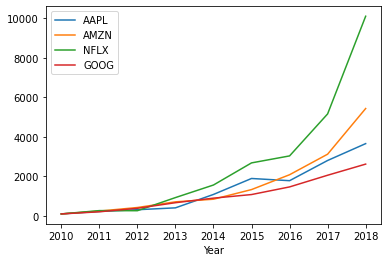

In [32]:
# simple plot of the returns on the aang stocks
qatar_stock_df.plot()

In [33]:
# concatenated the Paris Saint-Germain data and the AANG data into a single data frame using outer join since the time frames are different
# assume that the value of Paris Saint-Germain was static from 2010 (i.e. the year purchased the club) to 2013 (the first year that the revenue rose enough to be included in the Forbes list)
valuation_df = pd.concat([psg_valuation, qatar_stock_df], axis = "columns", join="outer" )
valuation_df = valuation_df.fillna(105.00)
valuation_df.drop([2019], inplace =True)
valuation_df

,Paris Saint-Germain,AAPL,AMZN,NFLX,GOOG
Year,,,,,
2010,105.0,105.000000,105.000000,105.000000,105.000000
2011,105.0,231.335991,249.318999,272.487700,212.428982
2012,105.0,317.669995,429.221525,267.450168,390.055724
2013,131.0,412.210350,716.570000,931.645858,672.500173
2014,415.0,1091.067492,849.061538,1568.086800,903.165610
2015,634.0,1898.451840,1336.885075,2687.585131,1085.219645
2016,814.0,1786.792695,2088.364239,3040.831795,1471.726589
2017,841.0,2809.620857,3128.303090,5166.463008,2062.684009
2018,971.0,3662.954673,5439.655469,10110.231188,2626.061335


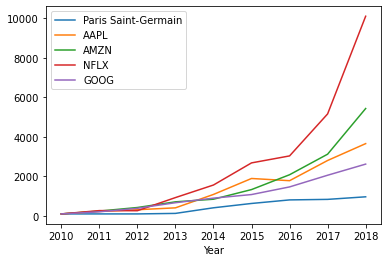

In [34]:
# Simple plot of the concatenated dataframe comparing the valuation of the 
valuation_df.plot()

In [35]:
# export the valuation_df as a csv so that it can be imported into a pyviz environment
valuation_df.to_csv(r"Resources/psg_v_aang.csv")

In [38]:
# import the deloitte money league csv which shows the yearly revenue for the top 20 soccer clubs for each year
complete_money_league_path = Path("Resources/complete_money_league_2010_2019.csv")
money_league_df = pd.read_csv(complete_money_league_path)
money_league_df = money_league_df.fillna(0)
money_league_df

,Season,Real Madrid,FC Barcelona,Manchester United,Bayern Munich,Chelsea,Arsenal,AC Milan,Liverpool,Schalke 04,...,Paris Saint-Germain,Galatasaray,Fenerbahçe,Atlético de Madrid,Everton,FC Zenit Saint Petersburg,West Ham United,Leicester City,Southampton,FC Internazionale Milano
0,2010-2011,479.5,450.7,367.0,321.4,253.1,251.1,234.8,211.4,202.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.4
1,2011-2012,512.6,483.0,395.9,368.4,322.6,290.3,256.9,233.2,178.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.9
2,2012-2013,518.9,482.6,423.8,431.2,303.4,284.3,263.5,240.6,198.2,...,398.8,157.0,126.4,120.0,0.0,0.0,0.0,0.0,0.0,164.5
3,2013-2014,549.5,484.8,518.0,487.5,387.9,359.3,305.9,305.9,214.0,...,471.3,161.9,0.0,169.9,144.1,0.0,0.0,0.0,0.0,162.8
4,2014-2015,577.0,560.8,560.8,474.0,420.0,435.5,199.1,391.8,219.7,...,480.8,0.0,0.0,176.6,165.1,169.3,0.0,0.0,0.0,164.8
5,2015-2016,620.1,620.2,689.0,592.0,447.4,468.5,224.5,403.8,224.5,...,520.9,0.0,0.0,228.6,0.0,196.5,192.3,172.1,0.0,179.2
6,2016-2017,674.6,648.3,676.3,587.8,428.0,487.6,0.0,424.2,230.2,...,587.8,0.0,0.0,272.5,199.2,0.0,230.2,271.1,212.1,262.1
7,2017-2018,750.9,690.4,665.8,629.2,505.7,439.2,207.7,568.4,243.8,...,541.7,0.0,0.0,304.4,212.9,0.0,197.9,0.0,0.0,304.4
8,2018-2019,757.3,840.8,711.5,660.1,513.1,445.6,0.0,610.6,324.8,...,635.9,0.0,0.0,367.6,216.4,0.0,216.4,0.0,0.0,367.6


In [39]:
# see the data types in order to help make decisions on how to clean, slice and dice the data
print(money_league_df.dtypes)

Season                        object
Real Madrid                  float64
FC Barcelona                 float64
Manchester United            float64
Bayern Munich                float64
Chelsea                      float64
Arsenal                      float64
AC Milan                     float64
Liverpool                    float64
Schalke 04                   float64
Tottenham Hotspur            float64
Manchester City              float64
Juventus                     float64
Olympique de Marseille       float64
AS Roma                      float64
Borussia Dortmund            float64
Olympique Lyonnais           float64
Hamburger SV                 float64
Valencia                     float64
Napoli                       float64
Newcastle United             float64
Paris Saint-Germain          float64
Galatasaray                  float64
Fenerbahçe                   float64
Atlético de Madrid           float64
Everton                      float64
FC Zenit Saint Petersburg    float64
W

In [40]:
# in order to have a consistent datetime index across all the data frames, the name of the season must be condensed into a single year. 
# In order to do this we must split the string into two columns.

seasons = money_league_df["Season"].str.split("-", expand=True)
money_league_df["Season 1"] = seasons[0]
money_league_df["Season 2"] = seasons[1]    
money_league_df

,Season,Real Madrid,FC Barcelona,Manchester United,Bayern Munich,Chelsea,Arsenal,AC Milan,Liverpool,Schalke 04,...,Fenerbahçe,Atlético de Madrid,Everton,FC Zenit Saint Petersburg,West Ham United,Leicester City,Southampton,FC Internazionale Milano,Season 1,Season 2
0,2010-2011,479.5,450.7,367.0,321.4,253.1,251.1,234.8,211.4,202.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.4,2010,2011
1,2011-2012,512.6,483.0,395.9,368.4,322.6,290.3,256.9,233.2,178.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.9,2011,2012
2,2012-2013,518.9,482.6,423.8,431.2,303.4,284.3,263.5,240.6,198.2,...,126.4,120.0,0.0,0.0,0.0,0.0,0.0,164.5,2012,2013
3,2013-2014,549.5,484.8,518.0,487.5,387.9,359.3,305.9,305.9,214.0,...,0.0,169.9,144.1,0.0,0.0,0.0,0.0,162.8,2013,2014
4,2014-2015,577.0,560.8,560.8,474.0,420.0,435.5,199.1,391.8,219.7,...,0.0,176.6,165.1,169.3,0.0,0.0,0.0,164.8,2014,2015
5,2015-2016,620.1,620.2,689.0,592.0,447.4,468.5,224.5,403.8,224.5,...,0.0,228.6,0.0,196.5,192.3,172.1,0.0,179.2,2015,2016
6,2016-2017,674.6,648.3,676.3,587.8,428.0,487.6,0.0,424.2,230.2,...,0.0,272.5,199.2,0.0,230.2,271.1,212.1,262.1,2016,2017
7,2017-2018,750.9,690.4,665.8,629.2,505.7,439.2,207.7,568.4,243.8,...,0.0,304.4,212.9,0.0,197.9,0.0,0.0,304.4,2017,2018
8,2018-2019,757.3,840.8,711.5,660.1,513.1,445.6,0.0,610.6,324.8,...,0.0,367.6,216.4,0.0,216.4,0.0,0.0,367.6,2018,2019


In [41]:
# drop the extra season columns so that we only have one column with one year representing the season
money_league_df.drop(columns=["Season", "Season 2"], inplace = True)
money_league_df

,Real Madrid,FC Barcelona,Manchester United,Bayern Munich,Chelsea,Arsenal,AC Milan,Liverpool,Schalke 04,Tottenham Hotspur,...,Galatasaray,Fenerbahçe,Atlético de Madrid,Everton,FC Zenit Saint Petersburg,West Ham United,Leicester City,Southampton,FC Internazionale Milano,Season 1
0,479.5,450.7,367.0,321.4,253.1,251.1,234.8,211.4,202.4,202.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.4,2010
1,512.6,483.0,395.9,368.4,322.6,290.3,256.9,233.2,178.2,178.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.9,2011
2,518.9,482.6,423.8,431.2,303.4,284.3,263.5,240.6,198.2,172.0,...,157.0,126.4,120.0,0.0,0.0,0.0,0.0,0.0,164.5,2012
3,549.5,484.8,518.0,487.5,387.9,359.3,305.9,305.9,214.0,215.5,...,161.9,0.0,169.9,144.1,0.0,0.0,0.0,0.0,162.8,2013
4,577.0,560.8,560.8,474.0,420.0,435.5,199.1,391.8,219.7,257.5,...,0.0,0.0,176.6,165.1,169.3,0.0,0.0,0.0,164.8,2014
5,620.1,620.2,689.0,592.0,447.4,468.5,224.5,403.8,224.5,279.7,...,0.0,0.0,228.6,0.0,196.5,192.3,172.1,0.0,179.2,2015
6,674.6,648.3,676.3,587.8,428.0,487.6,0.0,424.2,230.2,355.6,...,0.0,0.0,272.5,199.2,0.0,230.2,271.1,212.1,262.1,2016
7,750.9,690.4,665.8,629.2,505.7,439.2,207.7,568.4,243.8,428.3,...,0.0,0.0,304.4,212.9,0.0,197.9,0.0,0.0,304.4,2017
8,757.3,840.8,711.5,660.1,513.1,445.6,0.0,610.6,324.8,521.1,...,0.0,0.0,367.6,216.4,0.0,216.4,0.0,0.0,367.6,2018


In [42]:
money_league_df = money_league_df.rename(columns={"Season 1" : "Year"})
money_league_df

,Real Madrid,FC Barcelona,Manchester United,Bayern Munich,Chelsea,Arsenal,AC Milan,Liverpool,Schalke 04,Tottenham Hotspur,...,Galatasaray,Fenerbahçe,Atlético de Madrid,Everton,FC Zenit Saint Petersburg,West Ham United,Leicester City,Southampton,FC Internazionale Milano,Year
0,479.5,450.7,367.0,321.4,253.1,251.1,234.8,211.4,202.4,202.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.4,2010
1,512.6,483.0,395.9,368.4,322.6,290.3,256.9,233.2,178.2,178.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.9,2011
2,518.9,482.6,423.8,431.2,303.4,284.3,263.5,240.6,198.2,172.0,...,157.0,126.4,120.0,0.0,0.0,0.0,0.0,0.0,164.5,2012
3,549.5,484.8,518.0,487.5,387.9,359.3,305.9,305.9,214.0,215.5,...,161.9,0.0,169.9,144.1,0.0,0.0,0.0,0.0,162.8,2013
4,577.0,560.8,560.8,474.0,420.0,435.5,199.1,391.8,219.7,257.5,...,0.0,0.0,176.6,165.1,169.3,0.0,0.0,0.0,164.8,2014
5,620.1,620.2,689.0,592.0,447.4,468.5,224.5,403.8,224.5,279.7,...,0.0,0.0,228.6,0.0,196.5,192.3,172.1,0.0,179.2,2015
6,674.6,648.3,676.3,587.8,428.0,487.6,0.0,424.2,230.2,355.6,...,0.0,0.0,272.5,199.2,0.0,230.2,271.1,212.1,262.1,2016
7,750.9,690.4,665.8,629.2,505.7,439.2,207.7,568.4,243.8,428.3,...,0.0,0.0,304.4,212.9,0.0,197.9,0.0,0.0,304.4,2017
8,757.3,840.8,711.5,660.1,513.1,445.6,0.0,610.6,324.8,521.1,...,0.0,0.0,367.6,216.4,0.0,216.4,0.0,0.0,367.6,2018


In [43]:
money_league_df.set_index(pd.to_datetime(money_league_df["Year"], infer_datetime_format=True), inplace=True)
money_league_df= money_league_df.drop(columns=["Year"])
money_league_df

,Real Madrid,FC Barcelona,Manchester United,Bayern Munich,Chelsea,Arsenal,AC Milan,Liverpool,Schalke 04,Tottenham Hotspur,...,Paris Saint-Germain,Galatasaray,Fenerbahçe,Atlético de Madrid,Everton,FC Zenit Saint Petersburg,West Ham United,Leicester City,Southampton,FC Internazionale Milano
Year,,,,,,,,,,,,,,,,,,,,,
2010-01-01,479.5,450.7,367.0,321.4,253.1,251.1,234.8,211.4,202.4,202.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.4
2011-01-01,512.6,483.0,395.9,368.4,322.6,290.3,256.9,233.2,178.2,178.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.9
2012-01-01,518.9,482.6,423.8,431.2,303.4,284.3,263.5,240.6,198.2,172.0,...,398.8,157.0,126.4,120.0,0.0,0.0,0.0,0.0,0.0,164.5
2013-01-01,549.5,484.8,518.0,487.5,387.9,359.3,305.9,305.9,214.0,215.5,...,471.3,161.9,0.0,169.9,144.1,0.0,0.0,0.0,0.0,162.8
2014-01-01,577.0,560.8,560.8,474.0,420.0,435.5,199.1,391.8,219.7,257.5,...,480.8,0.0,0.0,176.6,165.1,169.3,0.0,0.0,0.0,164.8
2015-01-01,620.1,620.2,689.0,592.0,447.4,468.5,224.5,403.8,224.5,279.7,...,520.9,0.0,0.0,228.6,0.0,196.5,192.3,172.1,0.0,179.2
2016-01-01,674.6,648.3,676.3,587.8,428.0,487.6,0.0,424.2,230.2,355.6,...,587.8,0.0,0.0,272.5,199.2,0.0,230.2,271.1,212.1,262.1
2017-01-01,750.9,690.4,665.8,629.2,505.7,439.2,207.7,568.4,243.8,428.3,...,541.7,0.0,0.0,304.4,212.9,0.0,197.9,0.0,0.0,304.4
2018-01-01,757.3,840.8,711.5,660.1,513.1,445.6,0.0,610.6,324.8,521.1,...,635.9,0.0,0.0,367.6,216.4,0.0,216.4,0.0,0.0,367.6


In [44]:
money_league_df.index = money_league_df.index.year
money_league_df

,Real Madrid,FC Barcelona,Manchester United,Bayern Munich,Chelsea,Arsenal,AC Milan,Liverpool,Schalke 04,Tottenham Hotspur,...,Paris Saint-Germain,Galatasaray,Fenerbahçe,Atlético de Madrid,Everton,FC Zenit Saint Petersburg,West Ham United,Leicester City,Southampton,FC Internazionale Milano
Year,,,,,,,,,,,,,,,,,,,,,
2010,479.5,450.7,367.0,321.4,253.1,251.1,234.8,211.4,202.4,202.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.4
2011,512.6,483.0,395.9,368.4,322.6,290.3,256.9,233.2,178.2,178.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.9
2012,518.9,482.6,423.8,431.2,303.4,284.3,263.5,240.6,198.2,172.0,...,398.8,157.0,126.4,120.0,0.0,0.0,0.0,0.0,0.0,164.5
2013,549.5,484.8,518.0,487.5,387.9,359.3,305.9,305.9,214.0,215.5,...,471.3,161.9,0.0,169.9,144.1,0.0,0.0,0.0,0.0,162.8
2014,577.0,560.8,560.8,474.0,420.0,435.5,199.1,391.8,219.7,257.5,...,480.8,0.0,0.0,176.6,165.1,169.3,0.0,0.0,0.0,164.8
2015,620.1,620.2,689.0,592.0,447.4,468.5,224.5,403.8,224.5,279.7,...,520.9,0.0,0.0,228.6,0.0,196.5,192.3,172.1,0.0,179.2
2016,674.6,648.3,676.3,587.8,428.0,487.6,0.0,424.2,230.2,355.6,...,587.8,0.0,0.0,272.5,199.2,0.0,230.2,271.1,212.1,262.1
2017,750.9,690.4,665.8,629.2,505.7,439.2,207.7,568.4,243.8,428.3,...,541.7,0.0,0.0,304.4,212.9,0.0,197.9,0.0,0.0,304.4
2018,757.3,840.8,711.5,660.1,513.1,445.6,0.0,610.6,324.8,521.1,...,635.9,0.0,0.0,367.6,216.4,0.0,216.4,0.0,0.0,367.6


In [45]:
money_league_df.to_csv(r"Resources/cleaned_money_league_df.csv")

In [46]:
all_psg_sales = all_transfers[all_transfers["Team_from"].str.contains("Paris SG")]
all_psg_sales

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Market_value,Transfer_fee
Year,,,,,,,,,
2010,Stéphane Sessègnon,Attacking Midfield,26,Paris SG,Ligue 1,Sunderland,Premier League,8500000.0,7000000.0
2011,Mevlüt Erdinc,Centre-Forward,24,Paris SG,Ligue 1,Stade Rennais,Ligue 1,7250000.0,6600000.0
2013,Mamadou Sakho,Centre-Back,23,Paris SG,Ligue 1,Liverpool,Premier League,15000000.0,19000000.0
2013,Kévin Gameiro,Centre-Forward,26,Paris SG,Ligue 1,Sevilla FC,LaLiga,10000000.0,7500000.0
2015,Yohan Cabaye,Central Midfield,29,Paris SG,Ligue 1,Crystal Palace,Premier League,16000000.0,13900000.0
2015,Ezequiel Lavezzi,Second Striker,30,Paris SG,Ligue 1,HB CFFC,Super League,9000000.0,5500000.0
2016,David Luiz,Centre-Back,29,Paris SG,Ligue 1,Chelsea,Premier League,28000000.0,35000000.0
2016,Lucas Digne,Left-Back,22,Paris SG,Ligue 1,FC Barcelona,LaLiga,12000000.0,16500000.0
2016,Benjamin Stambouli,Centre-Back,26,Paris SG,Ligue 1,FC Schalke 04,1.Bundesliga,7000000.0,8000000.0


In [47]:
# get the number of transfers from psg each year
all_psg_sales_df = all_psg_sales.groupby([all_psg_sales.index])['Team_from'].value_counts().to_frame()
all_psg_sales_df = all_psg_sales_df.rename(columns={"Team_from" : "From Paris SG"})
clean_psg_sales_df = all_psg_sales_df.reset_index()
psg_cleaned_sales=clean_psg_sales_df.drop(columns= ["Team_from"])
psg_cleaned_sales=psg_cleaned_sales.set_index(["Year"])
psg_cleaned_sales

,From Paris SG
Year,
2010,1
2011,1
2013,2
2015,2
2016,3
2017,4
2018,4


In [48]:
# get the number of transfers to psg each year
all_psg_buys_df = all_psg_buys.groupby([all_psg_buys.index])['Team_to'].value_counts().to_frame()
all_psg_buys_df = all_psg_buys_df.rename(columns={"Team_to" : "To Paris SG"})
clean_psg_buys_df = all_psg_buys_df.reset_index()
psg_cleaned_buys=clean_psg_buys_df.drop(columns= ["Team_to"])
psg_cleaned_buys=psg_cleaned_buys.set_index(["Year"])
psg_cleaned_buys

,To Paris SG
Year,
2010,1
2011,9
2012,6
2013,4
2014,1
2015,5
2016,5
2017,2
2018,1


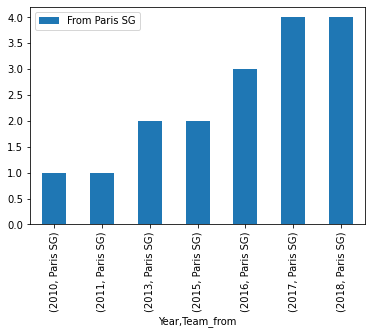

In [49]:
psg_sales_plot = all_psg_sales_df.plot(kind="bar")

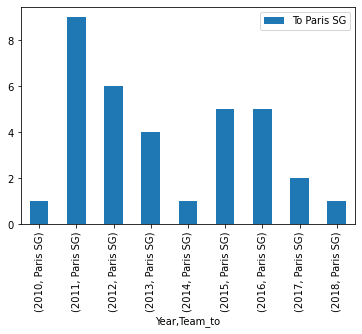

In [50]:
psg_buy_plot = all_psg_buys_df.plot(kind="bar")

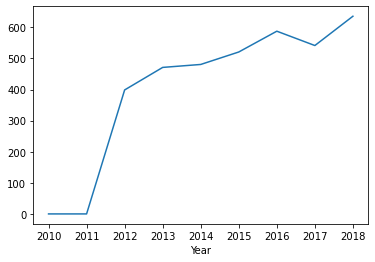

In [51]:
psg_revenue_plot = money_league_df["Paris Saint-Germain"].plot()

In [52]:
# get the transfer count for Real Madrid
all_madrid_sales = all_transfers[all_transfers["Team_from"].str.contains("Real Madrid")]
all_madrid_sales_df = all_madrid_sales.groupby([all_madrid_sales.index])['Team_from'].value_counts().to_frame()
all_madrid_sales_df = all_madrid_sales_df.rename(columns={"Team_from" : "From Real Madrid"})
clean_madrid_sales_df = all_madrid_sales_df.reset_index()
madrid_cleaned_sales=clean_madrid_sales_df.drop(columns= ["Team_from"])
madrid_cleaned_sales=madrid_cleaned_sales.set_index(["Year"])
madrid_cleaned_sales

,From Real Madrid
Year,
2010,1
2011,1
2012,5
2013,5
2014,4
2015,1
2016,2
2017,4
2018,2


In [53]:
all_madrid_buys = all_transfers[all_transfers["Team_to"].str.contains("Real Madrid")]
all_madrid_buys_df = all_madrid_buys.groupby([all_madrid_buys.index])['Team_to'].value_counts().to_frame()
all_madrid_buys_df = all_madrid_buys_df.rename(columns={"Team_to" : "To Real Madrid"})
clean_madrid_buys_df = all_madrid_buys_df.reset_index()
madrid_cleaned_buys=clean_madrid_buys_df.drop(columns= ["Team_to"])
madrid_cleaned_buys=madrid_cleaned_buys.set_index(["Year"])
madrid_cleaned_buys

,To Real Madrid
Year,
2010,6
2011,4
2012,1
2013,5
2014,4
2015,3
2016,1
2017,2
2018,3


In [54]:
# get the transfer count for Chelsea
all_chelsea_sales = all_transfers[all_transfers["Team_from"].str.contains("Chelsea")]
all_chelsea_sales_df = all_chelsea_sales.groupby([all_chelsea_sales.index])['Team_from'].value_counts().to_frame()
all_chelsea_sales_df = all_chelsea_sales_df.rename(columns={"Team_from" : "From Chelsea"})
clean_chelsea_sales_df = all_chelsea_sales_df.reset_index()
chelsea_cleaned_sales=clean_chelsea_sales_df.drop(columns= ["Team_from"])
chelsea_cleaned_sales=chelsea_cleaned_sales.set_index(["Year"])
chelsea_cleaned_sales

,From Chelsea
Year,
2010,2
2011,3
2012,2
2013,2
2014,5
2015,6
2016,4
2017,7


In [55]:
all_chelsea_buys = all_transfers[all_transfers["Team_to"].str.contains("Chelsea")]
all_chelsea_buys_df = all_chelsea_buys.groupby([all_chelsea_buys.index])['Team_to'].value_counts().to_frame()
all_chelsea_buys_df = all_chelsea_buys_df.rename(columns={"Team_to" : "To Chelsea"})
clean_chelsea_buys_df = all_chelsea_buys_df.reset_index()
chelsea_cleaned_buys=clean_chelsea_buys_df.drop(columns= ["Team_to"])
chelsea_cleaned_buys=chelsea_cleaned_buys.set_index(["Year"])
chelsea_cleaned_buys

,To Chelsea
Year,
2010,5
2011,8
2012,7
2013,6
2014,5
2015,4
2016,4
2017,8
2018,1


In [56]:
# get the transfer count for AC Milan
all_milan_sales = all_transfers[all_transfers["Team_from"].str.contains("AC Milan")]
all_milan_sales_df = all_milan_sales.groupby([all_milan_sales.index])['Team_from'].value_counts().to_frame()
all_milan_sales_df = all_milan_sales_df.rename(columns={"Team_from" : "From AC Milan"})
clean_milan_sales_df = all_milan_sales_df.reset_index()
milan_cleaned_sales=clean_milan_sales_df.drop(columns= ["Team_from"])
milan_cleaned_sales=milan_cleaned_sales.set_index(["Year"])
milan_cleaned_sales

,From AC Milan
Year,
2010,3
2011,3
2012,6
2013,2
2014,2
2016,2
2017,1
2018,2


In [57]:
all_milan_buys = all_transfers[all_transfers["Team_to"].str.contains("AC Milan")]
all_milan_buys_df = all_milan_buys.groupby([all_milan_buys.index])['Team_to'].value_counts().to_frame()
all_milan_buys_df = all_milan_buys_df.rename(columns={"Team_to" : "To AC Milan"})
clean_milan_buys_df = all_milan_buys_df.reset_index()
milan_cleaned_buys=clean_milan_buys_df.drop(columns= ["Team_to"])
milan_cleaned_buys=milan_cleaned_buys.set_index(["Year"])
milan_cleaned_buys

,To AC Milan
Year,
2010,4
2011,3
2012,5
2013,4
2014,2
2015,4
2016,3
2017,7
2018,2


In [58]:
# get the transfer count for FC Schalke 04
all_schalke_sales = all_transfers[all_transfers["Team_from"].str.contains("FC Schalke 04")]
all_schalke_sales_df = all_schalke_sales.groupby([all_schalke_sales.index])['Team_from'].value_counts().to_frame()
all_schalke_sales_df = all_schalke_sales_df.rename(columns={"Team_from" : "From FC Schalke 04"})
clean_schalke_sales_df = all_schalke_sales_df.reset_index()
schalke_cleaned_sales=clean_schalke_sales_df.drop(columns= ["Team_from"])
schalke_cleaned_sales=schalke_cleaned_sales.set_index(["Year"])
schalke_cleaned_sales

,From FC Schalke 04
Year,
2010,2
2011,1
2014,1
2015,3
2016,1
2018,1


In [59]:
all_schalke_buys = all_transfers[all_transfers["Team_to"].str.contains("FC Schalke 04")]
all_schalke_buys_df = all_schalke_buys.groupby([all_schalke_buys.index])['Team_to'].value_counts().to_frame() 
all_schalke_buys_df = all_schalke_buys_df.rename(columns={"Team_to" : "To FC Schalke 04"})
clean_schalke_buys_df = all_schalke_buys_df.reset_index()
schalke_cleaned_buys=clean_schalke_buys_df.drop(columns= ["Team_to"])
schalke_cleaned_buys=schalke_cleaned_buys.set_index(["Year"])
schalke_cleaned_buys

,To FC Schalke 04
Year,
2010,2
2011,1
2012,1
2013,2
2015,3
2016,2
2017,3
2018,3


In [61]:
combined_buysell = pd.concat([psg_cleaned_sales, psg_cleaned_buys, madrid_cleaned_sales, madrid_cleaned_buys, chelsea_cleaned_sales, chelsea_cleaned_buys,
milan_cleaned_sales, milan_cleaned_buys, schalke_cleaned_sales, schalke_cleaned_buys], axis="columns", join="outer" )
combined_buysell

,From Paris SG,To Paris SG,From Real Madrid,To Real Madrid,From Chelsea,To Chelsea,From AC Milan,To AC Milan,From FC Schalke 04,To FC Schalke 04
Year,,,,,,,,,,
2010,1.0,1,1,6,2.0,5,3.0,4,2.0,2.0
2011,1.0,9,1,4,3.0,8,3.0,3,1.0,1.0
2012,NaN,6,5,1,2.0,7,6.0,5,NaN,1.0
2013,2.0,4,5,5,2.0,6,2.0,4,NaN,2.0
2014,NaN,1,4,4,5.0,5,2.0,2,1.0,NaN
2015,2.0,5,1,3,6.0,4,NaN,4,3.0,3.0
2016,3.0,5,2,1,4.0,4,2.0,3,1.0,2.0
2017,4.0,2,4,2,7.0,8,1.0,7,NaN,3.0
2018,4.0,1,2,3,NaN,1,2.0,2,1.0,3.0


In [62]:
combined_buysell.to_csv(r"Resources/combined_buysell.csv")

In [63]:
# get the transfer fees paid by real madrid
all_madrid_buys = all_transfers[all_transfers["Team_to"].str.contains("Real Madrid")]
madrid_comparison_buys = (all_madrid_buys[["Transfer_fee"]].groupby([all_madrid_buys.index]).sum())
madrid_comparison_buys = madrid_comparison_buys.rename(columns={"Transfer_fee" : "Real Madrid"})
madrid_comparison_buys = madrid_comparison_buys/1000000
madrid_comparison_buys

,Real Madrid
Year,
2010,89.0
2011,55.0
2012,30.0
2013,175.5
2014,123.0
2015,68.5
2016,30.0
2017,40.5
2018,83.5


In [64]:
# get the transfer fees paid by Chelsea
all_chelsea_buys = all_transfers[all_transfers["Team_to"].str.contains("Chelsea")]
chelsea_comparison_buys = (all_chelsea_buys[["Transfer_fee"]].groupby([all_chelsea_buys.index]).sum())
chelsea_comparison_buys = chelsea_comparison_buys.rename(columns={"Transfer_fee" : "Chelsea"})
chelsea_comparison_buys = chelsea_comparison_buys/1000000
chelsea_comparison_buys

,Chelsea
Year,
2010,118.50
2011,92.65
2012,109.20
2013,123.00
2014,135.20
2015,66.00
2016,132.80
2017,257.80
2018,57.00


In [65]:
# get the transfer fees paid by AC Milan
all_milan_buys = all_transfers[all_transfers["Team_to"].str.contains("AC Milan")]
milan_comparison_buys = (all_milan_buys[["Transfer_fee"]].groupby([all_milan_buys.index]).sum())
milan_comparison_buys = milan_comparison_buys.rename(columns={"Transfer_fee" : "AC Milan"})
milan_comparison_buys = milan_comparison_buys/1000000
milan_comparison_buys

,AC Milan
Year,
2010,30.85
2011,47.00
2012,48.00
2013,31.50
2014,11.25
2015,83.00
2016,25.00
2017,176.00
2018,25.50


In [66]:
# get the transfer fees paid by FC Schalke 04
all_schalke_buys = all_transfers[all_transfers["Team_to"].str.contains("FC Schalke 04")]
schalke_comparison_buys = (all_schalke_buys[["Transfer_fee"]].groupby([all_schalke_buys.index]).sum())
schalke_comparison_buys = schalke_comparison_buys.rename(columns={"Transfer_fee" : "FC Schalke 04"})
schalke_comparison_buys = schalke_comparison_buys/1000000
schalke_comparison_buys

,FC Schalke 04
Year,
2010,25.0
2011,3.8
2012,4.0
2013,18.0
2015,26.0
2016,30.5
2017,39.5
2018,28.0


In [67]:
psg_comparison_buys_one = psg_comparison_buys.rename(columns={"Transfer_fee" : "Paris SG"})
psg_comparison_buys_one

,Paris SG
Year,
2010,5.00
2011,100.90
2012,149.95
2013,135.90
2014,49.50
2015,116.10
2016,132.50
2017,238.00
2018,135.00


In [68]:
combined_transfer_fees = pd.concat([psg_comparison_buys_one, schalke_comparison_buys, milan_comparison_buys, 
chelsea_comparison_buys, madrid_comparison_buys], axis="columns", join="outer" )
combined_transfer_fees

,Paris SG,FC Schalke 04,AC Milan,Chelsea,Real Madrid
Year,,,,,
2010,5.00,25.0,30.85,118.50,89.0
2011,100.90,3.8,47.00,92.65,55.0
2012,149.95,4.0,48.00,109.20,30.0
2013,135.90,18.0,31.50,123.00,175.5
2014,49.50,NaN,11.25,135.20,123.0
2015,116.10,26.0,83.00,66.00,68.5
2016,132.50,30.5,25.00,132.80,30.0
2017,238.00,39.5,176.00,257.80,40.5
2018,135.00,28.0,25.50,57.00,83.5


In [70]:
combined_transfer_fees.to_csv(r"Resources/combined_transfer_fees.csv")